In [50]:
import numpy as np
import pandas as pd
import yaml
import torch
import scanpy as sc
import scvi
import scib 

from scib_metrics.benchmark import Benchmarker

from copy import deepcopy
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics

from celldreamer.paths import DATA_DIR

from celldreamer.models.fm.ode import torch_wrapper
from tqdm import tqdm 
from pathlib import Path

device  = "cuda" if torch.cuda.is_available() else "cpu"

sc.set_figure_params(dpi=100, frameon=False, fontsize=12)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_types.py:9: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  IntOrKey = Union[int, jax.random.KeyArray]
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/utils/_utils.py:40: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  def validate_seed(seed: IntOrKey) -> jax.random.KeyArray:
/home/icb/alessandro.palma/miniconda3/en

In [22]:
adata = sc.read_h5ad(DATA_DIR / 'processed_full_genome' / 'neurips' / 'neurips_test.h5ad')

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# scVI

In [23]:
scvi.model.SCVI.setup_anndata(adata, layer="X_counts", batch_key="Site")

In [24]:
model = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")

In [25]:
model.train()

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/celldream ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/celldream ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIB

Epoch 400/400: 100%|██████████| 400/400 [05:17<00:00,  1.29it/s, v_num=1, train_loss_step=4.61e+3, train_loss_epoch=4.54e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [05:17<00:00,  1.26it/s, v_num=1, train_loss_step=4.61e+3, train_loss_epoch=4.54e+3]


In [26]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [27]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)

In [28]:
sc.tl.umap(adata)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


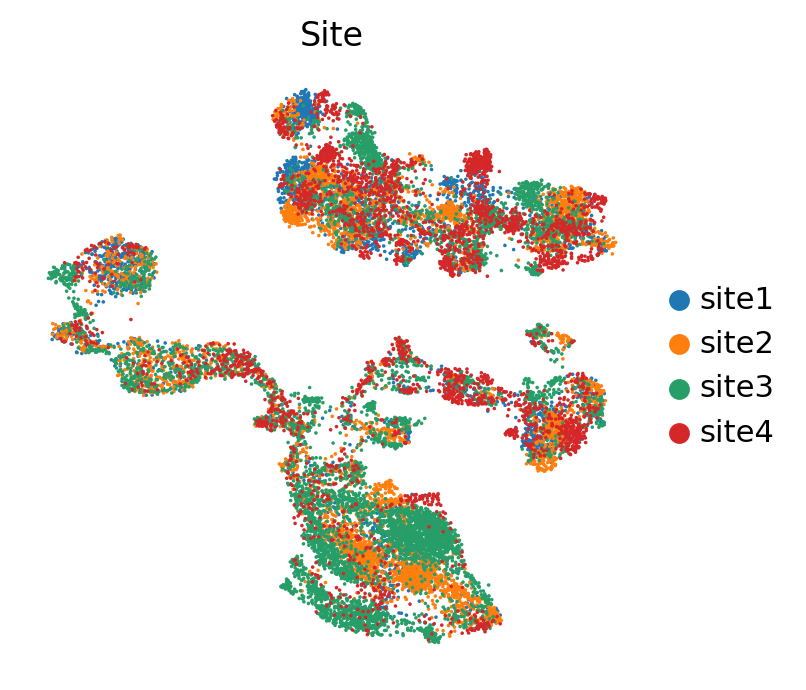

In [29]:
sc.pl.umap(adata, color="Site")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


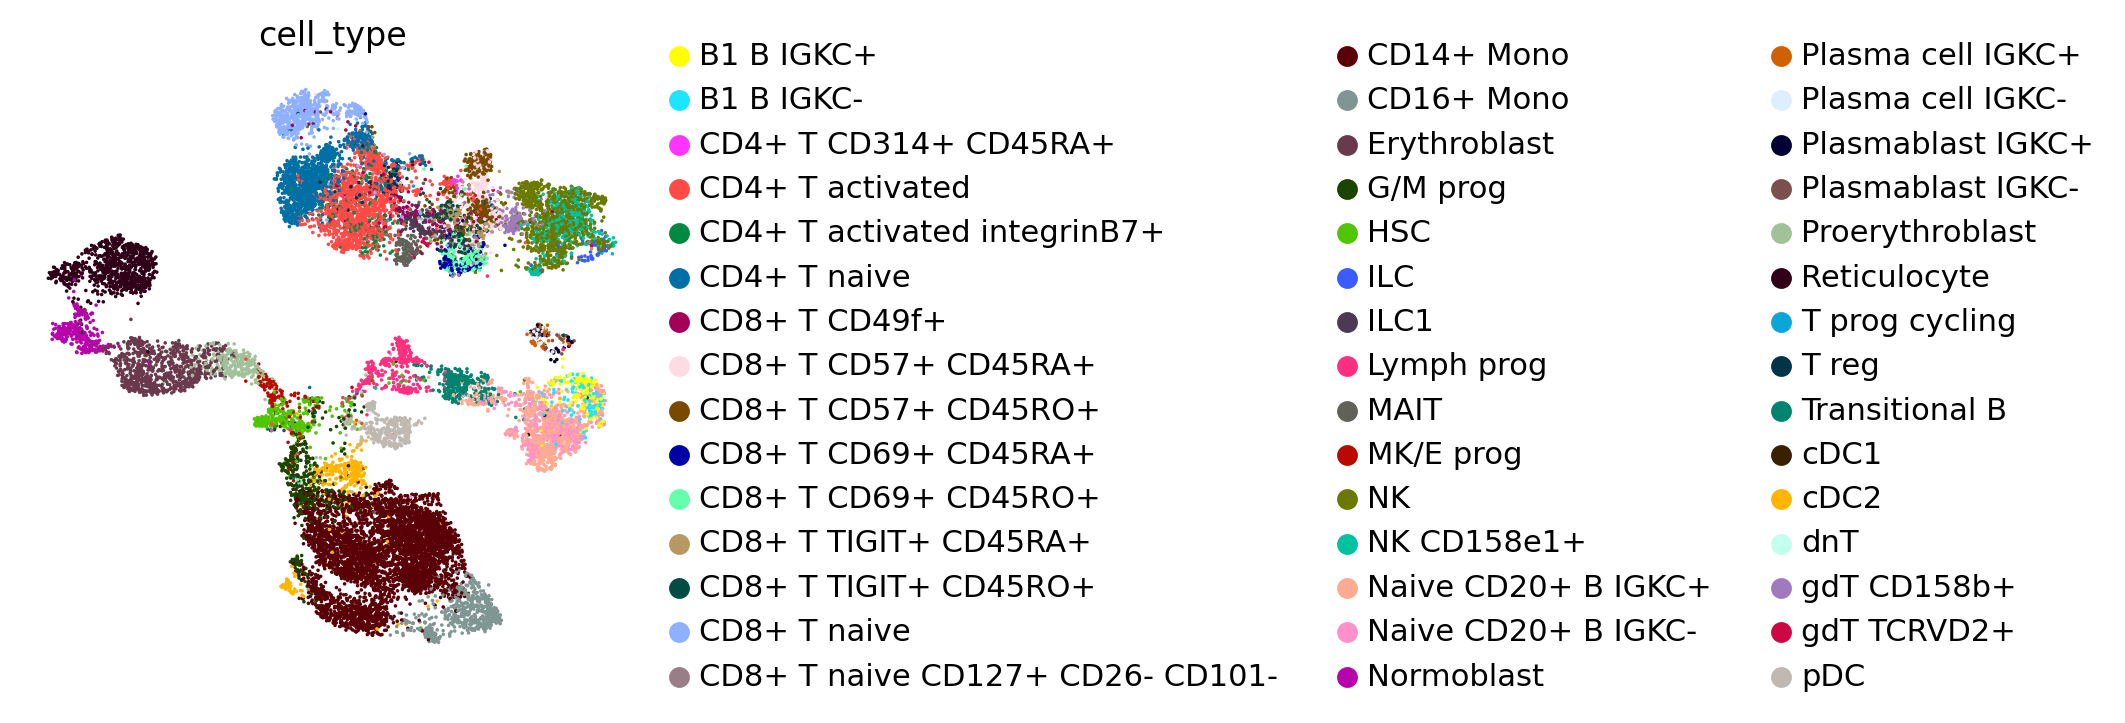

In [34]:
sc.pl.umap(adata, color="cell_type")

# scanVI

In [30]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=adata,
    labels_key="cell_type",
)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/data/fields/_dataframe_field.py:189: UserWarning: Category 36 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/data/fields/_scanvi.py:58: UserWarning: Category 36 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(


In [31]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/celldream ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/celldream ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIB

Epoch 20/20: 100%|██████████| 20/20 [00:43<00:00,  1.90s/it, v_num=1, train_loss_step=4.48e+3, train_loss_epoch=4.67e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:43<00:00,  2.17s/it, v_num=1, train_loss_step=4.48e+3, train_loss_epoch=4.67e+3]


In [32]:
SCANVI_LATENT_KEY = "X_scANVI"
adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)

In [37]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)

In [38]:
sc.tl.umap(adata)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


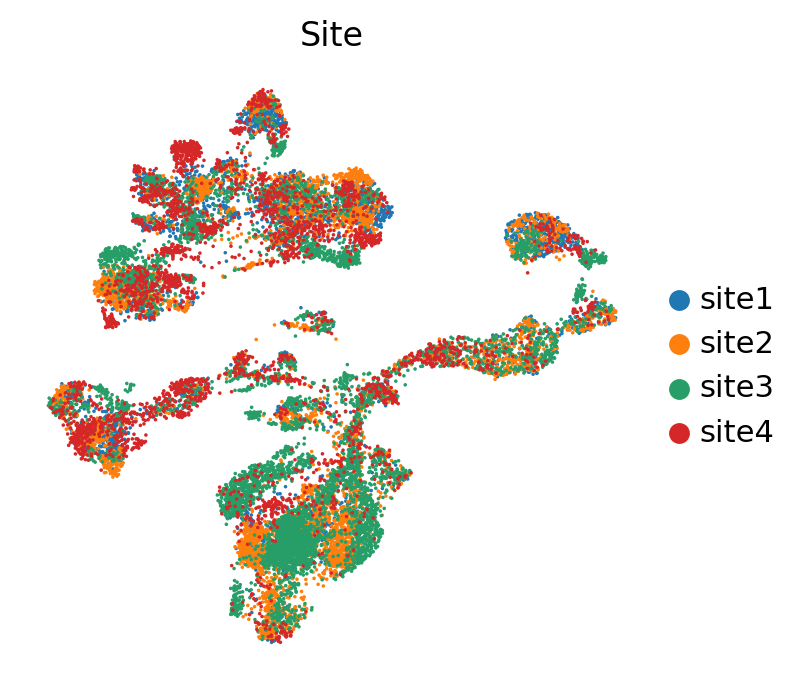

In [39]:
sc.pl.umap(adata, color="Site")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


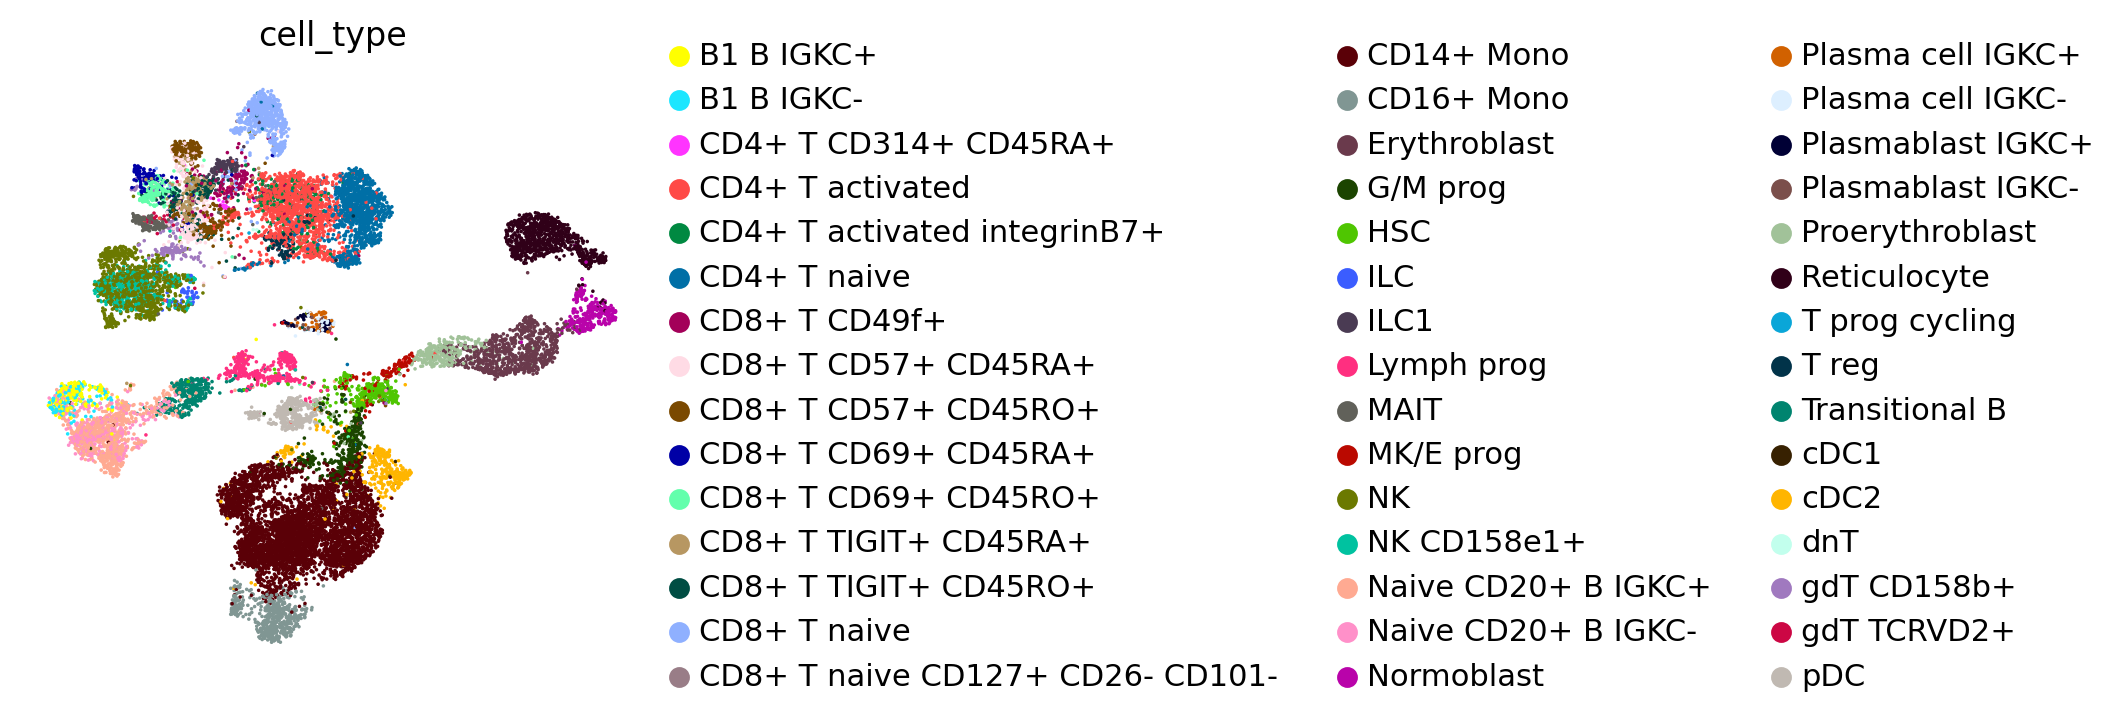

In [40]:
sc.pl.umap(adata, color="cell_type")

# Read cellFlow corrected dataset

In [73]:
adata_corrected_cellflow = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/generated/neurips_batch_correction/adata_corrected.h5ad")

In [74]:
adata_corrected_decoded_cellflow = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/generated/neurips_batch_correction/adata_corrected_decoded.h5ad")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


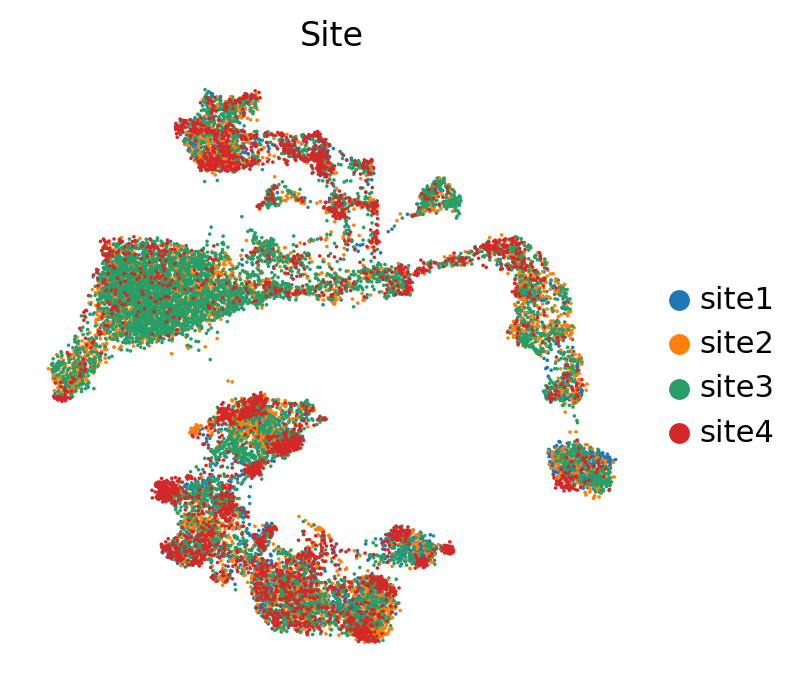

In [75]:
sc.pl.umap(adata_corrected_cellflow, color="Site")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


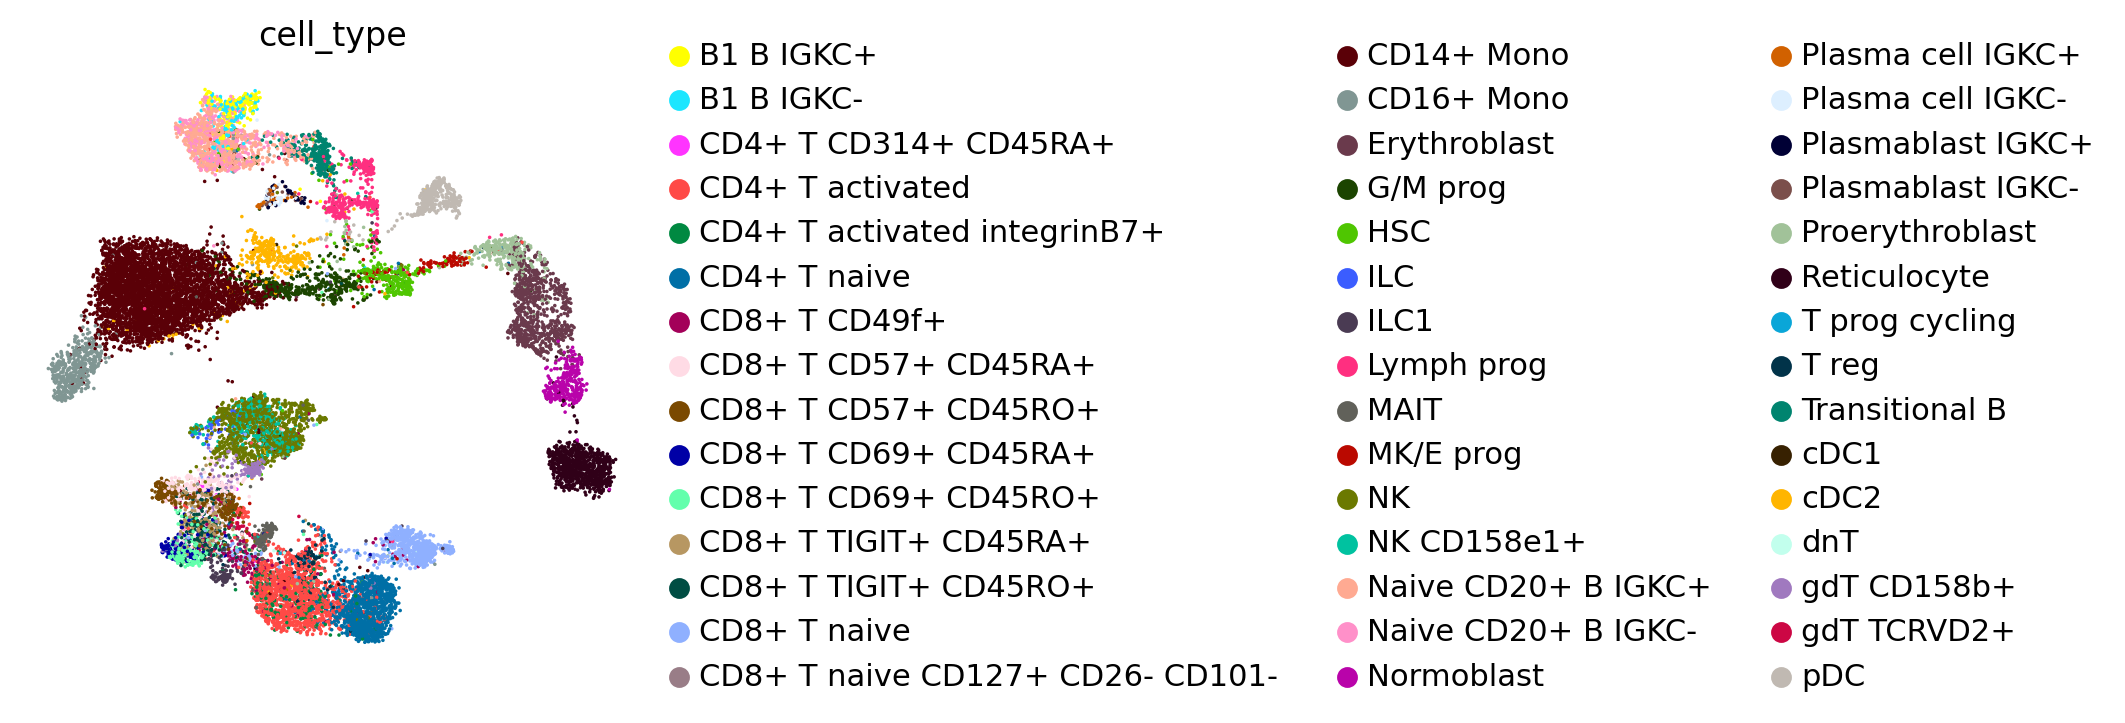

In [76]:
sc.pl.umap(adata_corrected_cellflow, color="cell_type")

In [77]:
adata.obsm["X_cellFlow"] = adata_corrected_cellflow.X.copy()

# Compute metrics

In [78]:
bm = Benchmarker(
    adata,
    batch_key="Site",
    label_key="cell_type",
    embedding_obsm_keys=["X_pca", SCVI_LATENT_KEY, SCANVI_LATENT_KEY,"X_cellFlow"],
    n_jobs=-1,
)
bm.benchmark()

Metrics:  60%|██████    | 6/10 [00:50<00:28,  7.24s/it, Batch correction: kbet_per_label]

INFO     CD4+ T CD314+ CD45RA+ consists of a single batch or is too small. Skip.                                   


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated 

INFO     CD8+ T naive CD127+ CD26- CD101- consists of a single batch or is too small. Skip.                        


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated 

INFO     T prog cycling consists of a single batch or is too small. Skip.                                          
INFO     cDC1 consists of a single batch or is too small. Skip.                                                    
INFO     dnT consists of a single batch or is too small. Skip.                                                     


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated 

INFO     CD4+ T CD314+ CD45RA+ consists of a single batch or is too small. Skip.                                   


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated 

INFO     CD8+ T naive CD127+ CD26- CD101- consists of a single batch or is too small. Skip.                        


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated 

INFO     T prog cycling consists of a single batch or is too small. Skip.                                          
INFO     cDC1 consists of a single batch or is too small. Skip.                                                    
INFO     dnT consists of a single batch or is too small. Skip.                                                     


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated 

INFO     CD4+ T CD314+ CD45RA+ consists of a single batch or is too small. Skip.                                   


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated 

INFO     CD8+ T naive CD127+ CD26- CD101- consists of a single batch or is too small. Skip.                        


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated 

INFO     T prog cycling consists of a single batch or is too small. Skip.                                          
INFO     cDC1 consists of a single batch or is too small. Skip.                                                    
INFO     dnT consists of a single batch or is too small. Skip.                                                     


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated 

INFO     CD4+ T CD314+ CD45RA+ consists of a single batch or is too small. Skip.                                   


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated 

INFO     CD8+ T naive CD127+ CD26- CD101- consists of a single batch or is too small. Skip.                        


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated 

INFO     T prog cycling consists of a single batch or is too small. Skip.                                          
INFO     cDC1 consists of a single batch or is too small. Skip.                                                    
INFO     dnT consists of a single batch or is too small. Skip.                                                     


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated 

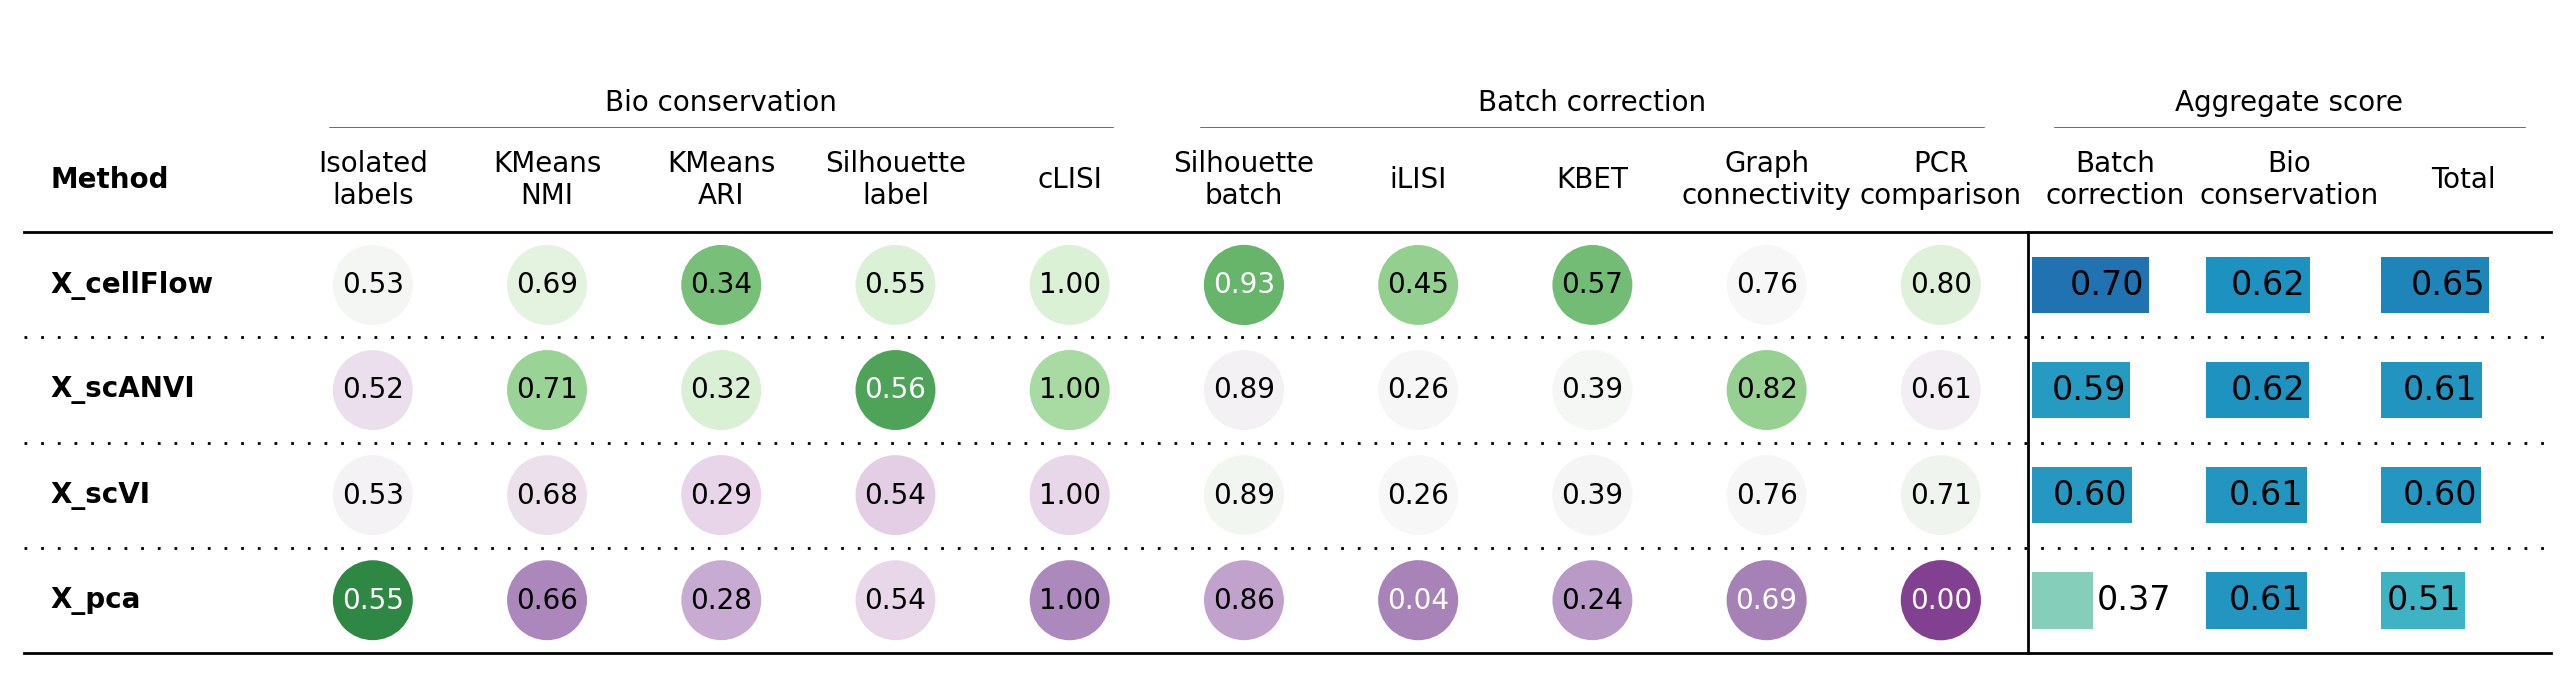

In [79]:
bm.plot_results_table(min_max_scale=False)

In [80]:
adata.obs.cell_type

TTCCGGTAGTTGTAAG-1-s1d1              CD14+ Mono
ACCATTTCACTCACTC-1-s1d1                      NK
CGGAACCCAGCATGCC-1-s1d1            Reticulocyte
CTGTGGGAGCCTGTGC-1-s1d1            CD4+ T naive
TGCTGAAGTTTCTATC-1-s1d1              B1 B IGKC-
                                   ...         
TCGTCCAGTGCTTATG-1-s4d9            CD8+ T naive
GAGCCTGGTATCAGCT-1-s4d9    CD8+ T CD57+ CD45RO+
GCTGGGTGTACGGATG-1-s4d9            CD8+ T naive
TCGAAGTGTGACAGGT-1-s4d9                   T reg
ACGTAACAGGTCTACT-1-s4d9            CD8+ T naive
Name: cell_type, Length: 18053, dtype: category
Categories (45, object): ['B1 B IGKC+', 'B1 B IGKC-', 'CD4+ T CD314+ CD45RA+', 'CD4+ T activated', ..., 'dnT', 'gdT CD158b+', 'gdT TCRVD2+', 'pDC']

In [81]:
adata.obs.Site

TTCCGGTAGTTGTAAG-1-s1d1    site1
ACCATTTCACTCACTC-1-s1d1    site1
CGGAACCCAGCATGCC-1-s1d1    site1
CTGTGGGAGCCTGTGC-1-s1d1    site1
TGCTGAAGTTTCTATC-1-s1d1    site1
                           ...  
TCGTCCAGTGCTTATG-1-s4d9    site4
GAGCCTGGTATCAGCT-1-s4d9    site4
GCTGGGTGTACGGATG-1-s4d9    site4
TCGAAGTGTGACAGGT-1-s4d9    site4
ACGTAACAGGTCTACT-1-s4d9    site4
Name: Site, Length: 18053, dtype: category
Categories (4, object): ['site1', 'site2', 'site3', 'site4']